In [1]:
import librosa
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
#DATA_PATH="./Vowel_Data/Vowel/"
DATA_PATH="./Word_Data/Word/"

def get_labels(path=DATA_PATH):
    labels=os.listdir(path)
    label_indices=np.arange(0,len(labels))
    return labels, label_indices, to_categorical(label_indices)

In [3]:
def speech2mfcc(file_path,max_len=13):
    wave, sr= librosa.load(file_path, mono=True, sr=None)
    wave=wave[::5]
    mfcc=librosa.feature.mfcc(wave,sr=sr)
    if (max_len > mfcc.shape[1]): #.shape[1], 1-->column
        pad_width=max_len-mfcc.shape[1]
        mfcc=np.pad(mfcc,pad_width=((0,0),(0,pad_width)),mode='constant')
    else:
        mfcc=mfcc[:,:max_len]
    return mfcc

In [4]:
def save_data_to_array(path=DATA_PATH, max_len=13):
    labels,_,_=get_labels(path)

    for label in labels:
        mfcc_vectors=[]

        speechfiles=[path + label + '/' + speech for speech in os.listdir(path+'/'+label)]
        for speech in tqdm(speechfiles,"Saving vectors to label -'{}'".format(label)):
            mfcc=speech2mfcc(speech,max_len=max_len)
            mfcc_vectors.append(mfcc)
            
        np.save(label+'.npy',mfcc_vectors)

In [5]:
save_data_to_array()

Saving vectors to label -'Word7': 100%|██████████| 40/40 [00:03<00:00, 12.07it/s]


In [6]:
def get_train_test(split_ratio=0.8,random_state=42):
    labels,indices,_=get_labels(DATA_PATH)

    X=np.load(labels[0]+'.npy')
    y=np.zeros(X.shape[0])

    for i,label in enumerate(labels[1:]):
        x=np.load(label+'.npy')
        X=np.vstack((X,x))
        y=np.append(y,np.full(x.shape[0],fill_value=(i+1)))
    assert X.shape[0] == len(y)
    return train_test_split(X,y,test_size=(1-split_ratio),random_state=random_state,shuffle=True)

In [7]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [8]:
X_train, X_test, y_train, y_test=get_train_test()
#print(X_train.shape)
X_train=X_train.reshape(X_train.shape[0],20,13,1)
X_test=X_test.reshape(X_test.shape[0],20,13,1)
y_train_hot=to_categorical(y_train)
y_test_hot=to_categorical(y_test)

In [15]:
model=Sequential()
model.add(Conv2D(64,kernel_size=(2,2),activation='tanh',input_shape=(20,13,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(7,activation='softmax'))

In [16]:
model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.adadelta(),metrics=['accuracy'])
history=model.fit(X_train,y_train_hot,batch_size=128,epochs=20,verbose=1,validation_data=(X_test,y_test_hot))
#history=model.fit(X_train,y_train_hot,batch_size=128,epochs=20,verbose=1)

Train on 224 samples, validate on 56 samples
Epoch 1/20
224/224 [==============================] - 1s 3ms/step - loss: 3.3599 - acc: 0.1607 - val_loss: 2.5078 - val_acc: 0.2679
Epoch 2/20
224/224 [==============================] - 0s 670us/step - loss: 2.7585 - acc: 0.2054 - val_loss: 2.1935 - val_acc: 0.2857
Epoch 3/20
224/224 [==============================] - 0s 753us/step - loss: 1.7524 - acc: 0.3438 - val_loss: 1.4594 - val_acc: 0.4464
Epoch 4/20
224/224 [==============================] - 0s 748us/step - loss: 1.3089 - acc: 0.5223 - val_loss: 1.7312 - val_acc: 0.4286
Epoch 5/20
224/224 [==============================] - 0s 754us/step - loss: 1.6617 - acc: 0.4420 - val_loss: 2.0724 - val_acc: 0.3929
Epoch 6/20
224/224 [==============================] - 0s 739us/step - loss: 1.5158 - acc: 0.5223 - val_loss: 1.2035 - val_acc: 0.5536
Epoch 7/20
224/224 [==============================] - 0s 725us/step - loss: 0.9056 - acc: 0.7009 - val_loss: 0.9682 - val_acc: 0.6964
Epoch 8/20
224/224 

In [13]:
history_dict=history.history
final_loss=history_dict['loss'][-1]
final_acc=history_dict['acc'][-1]

In [14]:
final_acc

0.9776785629136222

In [81]:
np.save('./Result/Training_trial7.npy',[final_loss, final_acc])

In [17]:
history_dict=history.history
loss_values=history_dict['loss']
val_loss_values=history_dict['val_loss']
epochs=range(1,len(loss_values)+1)

In [59]:
np.load('./Result/Training_trial5.npy')

array([0.17341404, 0.93333334])

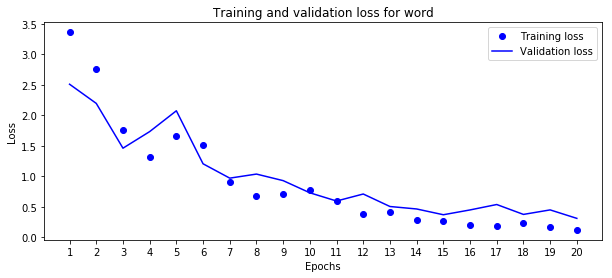

In [18]:
plt.figure(figsize=(10,4))
plt.plot(epochs,loss_values,'bo',label='Training loss')
plt.plot(epochs,val_loss_values,'b',label='Validation loss')
plt.title('Training and validation loss for word')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.show()
plt.savefig('loss_word_with_CNN.png',format='png', dpi=1200)

In [19]:
plt.clf()
acc_values=history_dict['acc']
val_acc_values=history_dict['val_acc']

<Figure size 432x288 with 0 Axes>

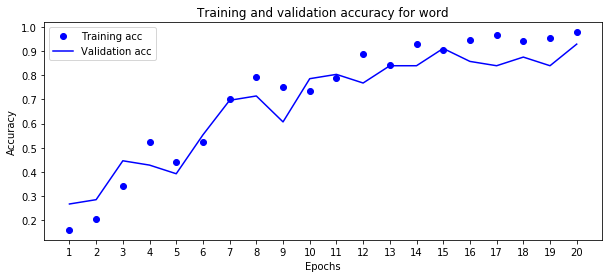

In [20]:
plt.figure(figsize=(10,4))
plt.plot(epochs,acc_values,'bo',label='Training acc')
plt.plot(epochs,val_acc_values,'b',label='Validation acc')
plt.title('Training and validation accuracy for word')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#plt.show()
plt.savefig('accuracy_word_with_CNN.png',format='png', dpi=1200)

In [205]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 19, 10, 64)        320       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 9, 5, 64)          0         
_________________________________________________________________
dropout_53 (Dropout)         (None, 9, 5, 64)          0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 2880)              0         
_________________________________________________________________
dense_53 (Dense)             (None, 128)               368768    
_________________________________________________________________
dropout_54 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_54 (Dense)             (None, 10)                1290      
Total para